In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
!gdown 1zJ1gQC97E-RWQ8q3L8sHg9CwFUmjd6c-

Downloading...
From: https://drive.google.com/uc?id=1zJ1gQC97E-RWQ8q3L8sHg9CwFUmjd6c-
To: /content/tiny_nerf_data.npz
100% 12.7M/12.7M [00:00<00:00, 40.2MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

In [ ]:
L_embed = 6

## NeRF Model Instructions

## 1. Number of Layers:
##    - The model consists of three fully connected (linear) layers.

## 2. Input Size:
##    - The input includes 3D coordinates (x, y, z).
##    - Positional encoding expands the input dimension.
##    - The final input size is 3 + 3 * 2 * L_embed.

## 3. Hidden Layers:
##    - The first hidden layer maps the input to a feature space of size `filter_size`.
##    - The second hidden layer maintains the same `filter_size` dimension.
##    - Use ReLU as the activation function after these layers.

## 4. Output Layer:
##    - The final layer outputs a 4D vector.
##    - This output typically represents RGB color (3 channels) and a density (1 channel).

class NeRF(torch.nn.Module):
    """
    NeRF MLP model
    """
    def __init__(self, filter_size=128, L_embed=6):
        super(NeRF, self).__init__()

    def forward(self, x):

        return x


NeRF optimization start


  0%|          | 0/1000 [00:00<?, ?it/s]

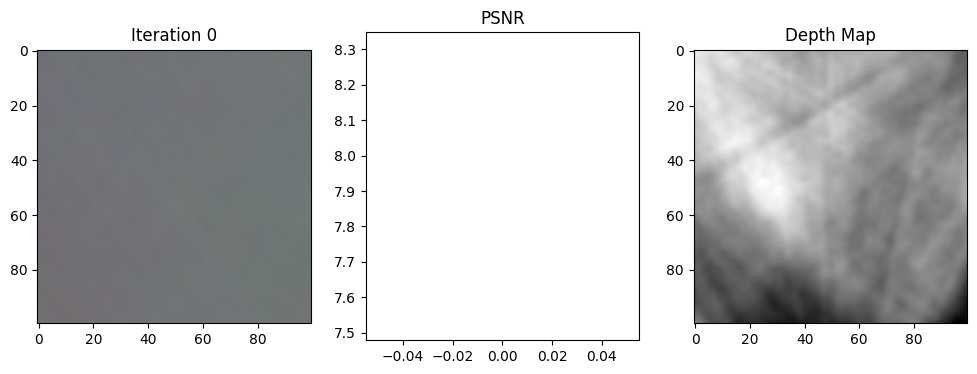

 10%|▉         | 99/1000 [00:08<01:07, 13.38it/s]

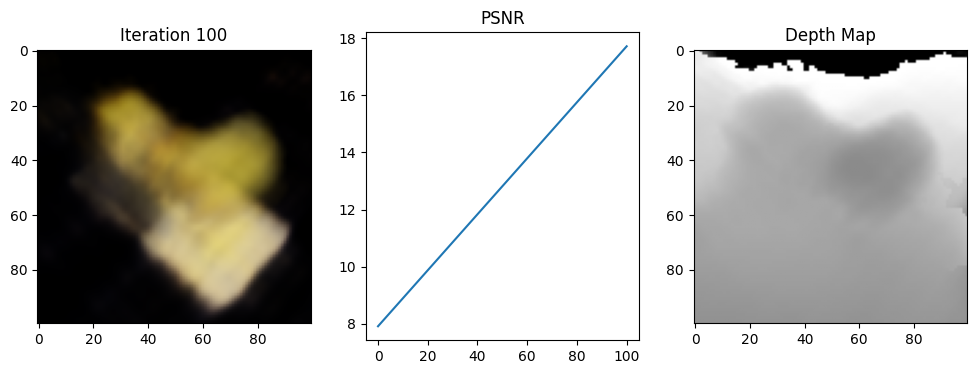

 20%|█▉        | 199/1000 [00:17<01:00, 13.19it/s]

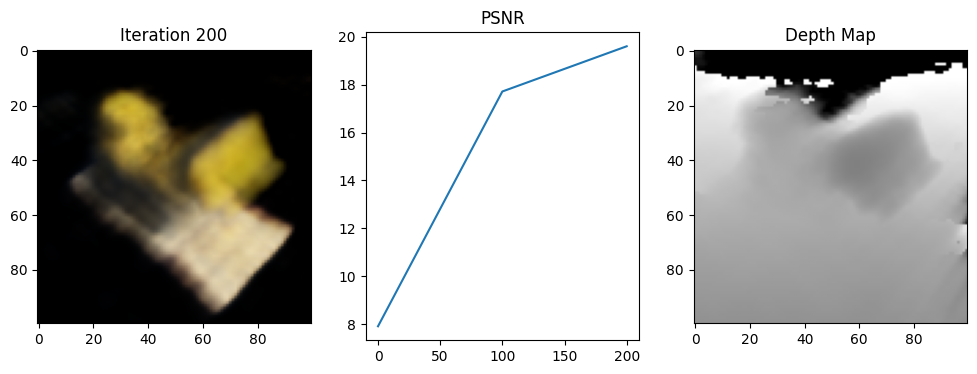

 23%|██▎       | 231/1000 [00:21<00:58, 13.18it/s]

In [ ]:
def posenc(x):
    """
    Positional encoding
    """
    rets = [x]
    for i in range(L_embed):
        for fn in [torch.sin, torch.cos]:
            rets.append(fn(2.0 ** i * x))
    return torch.cat(rets, dim=-1)

embed_fn = posenc

def get_rays(H, W, focal, c2w):
    """
    Get ray origin, direction to each image pixels based on camera pose
    """
    def meshgrid_xy(tensor1, tensor2):
        i, j = torch.meshgrid(tensor1, tensor2, indexing="ij")
        return i.transpose(-1, -2), j.transpose(-1, -2)

    i, j = meshgrid_xy(
        torch.arange(W, dtype=torch.float32).to(device),
        torch.arange(H, dtype=torch.float32).to(device)
    )
    dirs = torch.stack([(i-W*0.5)/focal, -(j-H*0.5)/focal, -torch.ones_like(i).to(device)], dim=-1).to(device)
    rays_d = torch.sum(dirs[..., None, :].to(device) * c2w[:3, :3].to(device), dim=-1)
    rays_o = c2w[:3, -1].expand(rays_d.shape)
    return rays_o.to(device), rays_d.to(device)

def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):
    """
    Volume rendering
    """
    def batchify(fn, chunk=1024*32):
        return lambda inputs : torch.cat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], dim=0)

    def exclusive_cumprod(tensor):
        cumprod = torch.cumprod(tensor, dim=-1)
        cumprod = torch.roll(cumprod, 1, dims=-1)
        cumprod[..., 0] = 1.0
        return cumprod

    # Compute 3D query points
    z_vals = torch.linspace(near, far, N_samples).to(device)
    if rand:
        z_vals = z_vals + torch.rand(list(rays_o.shape[:-1]) + [N_samples]).to(device) * (far-near)/N_samples
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]

    # Run network
    pts_flat = torch.reshape(pts, [-1, 3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = torch.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities and color
    sigma_a = torch.nn.functional.relu(raw[..., 3])
    rgb = torch.sigmoid(raw[..., :3])

    # Do volume rendering
    dists = torch.cat([z_vals[..., 1:] - z_vals[..., :-1], torch.tensor([1e10], device=device).expand(z_vals[..., :1].shape)], dim=-1)
    alpha = 1.0 - torch.exp(-sigma_a * dists)
    weights = alpha * exclusive_cumprod(1.0-alpha + 1e-10)
    rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)
    depth_map = torch.sum(weights * z_vals, dim=-1)
    acc_map = torch.sum(weights, dim=-1)

    return rgb_map, depth_map, acc_map

if __name__ == "__main__":
    data = np.load('tiny_nerf_data.npz')
    images = data['images']
    poses = data['poses']
    focal = data['focal']

    images = torch.from_numpy(images).to(device)
    poses = torch.from_numpy(poses).to(device)
    focal = torch.from_numpy(focal).to(device)

    H, W = images.shape[1:3]

    # Define test set, training set
    testimg, testpose = images[101], poses[101]
    images = images[:100,...,:3]
    poses = poses[:100]

    # Hyperparameters
    N_samples = 64
    N_iters = 10000
    psnrs = []
    iternums = []
    i_plot = 100
    lr = 5e-3

    # Define NeRF model, optimizer
    model = NeRF()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # NeRF optimization loop
    print("NeRF optimization start")
    plot_image = True

    for i in tqdm(range(N_iters)):
        img_i = np.random.randint(images.shape[0])
        target = images[img_i].to(device)
        pose = poses[img_i].to(device)
        rays_o, rays_d = get_rays(H, W, focal, pose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2.0, far=6.0, N_samples=N_samples, rand=True)

        # Back propagation
        loss = torch.nn.functional.mse_loss(rgb, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if plot_image:
            if i % i_plot == 0:
                rays_o, rays_d = get_rays(H, W, focal, testpose)
                rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2.0, far=6.0, N_samples=N_samples)
                loss = torch.nn.functional.mse_loss(rgb, testimg)
                psnr = -10.0 * torch.log10(loss)

                psnrs.append(psnr.item())
                iternums.append(i)

                plt.figure(figsize=(12, 4))
                plt.subplot(131)
                plt.imshow(rgb.cpu().detach().numpy())
                plt.title(f"Iteration {i}")
                plt.subplot(132)
                plt.plot(iternums, psnrs)
                plt.title("PSNR")
                plt.subplot(133)
                plt.imshow(depth.cpu().detach().numpy(), cmap="gray")
                plt.title("Depth Map")

                # Auto close
                plt.show(block=False)
                plt.pause(1)
                plt.close()

    print("Done")

    save_video = True
    if save_video:
        print("Video save start")
        import imageio

        trans_t = lambda t : np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, t],
            [0, 0, 0, 1]
        ], dtype=np.float32)

        rot_phi = lambda phi : np.array([
            [1, 0, 0, 0],
            [0, np.cos(phi), -np.sin(phi), 0],
            [0, np.sin(phi), np.cos(phi), 0],
            [0, 0, 0, 1]
        ], dtype=np.float32)

        rot_theta = lambda th : np.array([
            [np.cos(th), 0, -np.sin(th), 0],
            [0, 1, 0, 0],
            [np.sin(th), 0, np.cos(th), 0],
            [0, 0, 0, 1]
        ], dtype=np.float32)

        def pose_spherical(theta, phi, radius):
            c2w = trans_t(radius)
            c2w = rot_phi(phi/180.0*np.pi) @ c2w
            c2w = rot_theta(theta/180.0*np.pi) @ c2w
            c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
            return torch.from_numpy(c2w).float().to(device)

        frames = []

        for th in tqdm(np.linspace(0.0, 360.0, 120, endpoint=False)):
            c2w = pose_spherical(th, -30.0, 4.0)
            rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
            rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2.0, far=6.0, N_samples=N_samples)
            rgb = rgb.detach().cpu().numpy()
            frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

        f = 'video.mp4'
        imageio.mimwrite(f, frames, fps=30, quality=7)
        print("Done")

Done
